# 해외 축구 선수 이적료 예측 미션

* 패키지 임포트

In [1]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV , KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import catboost as cb
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
pd.set_option('mode.chained_assignment',  None)
from scipy.stats import skew
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from matplotlib import font_manager,rc # 한글 글꼴 사용
rc('font', family='AppleGothic') 

pd.set_option('display.max_row',100)
pd.set_option('display.max_column',100)

---

* 데이터 불러오기

In [2]:
train = pd.read_csv('FIFA_train.csv')
test = pd.read_csv('FIFA_test.csv')
submission = pd.read_csv('submission.csv')

* 전체 데이터 비율

In [3]:
print('train data ratio :',len(train)/(len(train)+len(test)))
print('test data ratio :',len(test)/(len(train)+len(test)))

train data ratio : 0.7
test data ratio : 0.3


* 데이터 확인

In [4]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [5]:
test.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0


* 데이터 분포 확인

In [6]:
train.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [7]:
test.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves
count,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000
mean,7846.258098,25.297806,1.143939,67.336991,72.107628,2.414838
std,4870.339361,4.628236,0.448465,6.908814,6.133428,0.781153
min,1.000000,16.000000,1.000000,47.000000,52.000000,1.000000
25%,3466.250000,22.000000,1.000000,63.000000,68.000000,2.000000
50%,7643.500000,25.000000,1.000000,67.000000,72.000000,2.000000
75%,11967.000000,29.000000,1.000000,72.000000,76.000000,3.000000
max,16943.000000,42.000000,5.000000,94.000000,95.000000,5.000000


자료들의 최소,최대값이 크게 벗어나는건 없는것 같습니다.  

* 데이터 정보 확인

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3828 non-null   int64  
 1   name              3828 non-null   object 
 2   age               3828 non-null   int64  
 3   continent         3828 non-null   object 
 4   contract_until    3828 non-null   object 
 5   position          3828 non-null   object 
 6   prefer_foot       3828 non-null   object 
 7   reputation        3828 non-null   float64
 8   stat_overall      3828 non-null   int64  
 9   stat_potential    3828 non-null   int64  
 10  stat_skill_moves  3828 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 329.1+ KB


* 결측치 확인

In [10]:
train.isnull().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
value               0
dtype: int64

In [11]:
test.isnull().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
dtype: int64

  
  결측지도 없는것으로 보입니다.

* 중복값 확인

In [12]:
train[train.duplicated()]

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value


In [13]:
test[test.duplicated()]

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves


중복값도 확인되지 않습니다.

* 필요없는 변수 제거
* id, name은 분석에 사용되지 않기때문에 제거합니다.

In [14]:
train.drop(['id','name'],axis=1,inplace=True)
test.drop(['id','name'],axis=1,inplace=True)

## 데이터 구조 확인

* 학습데이터 변수 확인

In [15]:
train['age'].unique()

array([31, 27, 32, 25, 26, 29, 33, 30, 40, 24, 28, 34, 23, 22, 35, 36, 21,
       18, 19, 37, 20, 39, 17, 38, 16])

In [16]:
train['continent'].unique()

array(['south america', 'europe', 'africa', 'asia', 'oceania'],
      dtype=object)

In [17]:
train['contract_until'].unique()
# 변수 확인 필요

array(['2021', '2020', '2019', '2023', '2022', '2024', 'Jun 30, 2019',
       '2026', 'Dec 31, 2018', '2018', '2025', 'Jun 30, 2020',
       'May 31, 2020', 'May 31, 2019', 'Jan 31, 2019', 'Jan 1, 2019',
       'Jan 12, 2019'], dtype=object)

데이터 구조를 통일시켜야 할 것 같습니다.

In [18]:
train['position'].unique()

array(['ST', 'GK', 'DF', 'MF'], dtype=object)

In [19]:
train['prefer_foot'].unique()

array(['left', 'right'], dtype=object)

In [20]:
train['reputation'].unique()

array([5., 4., 3., 1., 2.])

In [21]:
train['stat_overall'].unique()

array([94, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76,
       75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59,
       58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47])

In [22]:
train['stat_potential'].unique()

array([94, 93, 91, 90, 92, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78,
       77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61,
       60, 59, 58, 57, 56, 55, 54, 53, 52, 50, 48])

In [23]:
train['stat_skill_moves'].unique()

array([4., 1., 3., 2., 5.])

* 테스트 데이터 변수 확인

In [24]:
test['age'].unique()

array([33, 26, 27, 32, 29, 28, 24, 30, 19, 25, 31, 22, 23, 37, 35, 34, 36,
       21, 20, 40, 38, 18, 39, 17, 42, 16])

In [25]:
test['continent'].unique()

array(['europe', 'south america', 'africa', 'asia', 'oceania'],
      dtype=object)

In [26]:
test['contract_until'].unique()
# 변수 확인 필요

array(['2022', '2023', '2020', '2021', 'Jun 30, 2019', '2019', '2025',
       '2024', '2018', 'May 31, 2020', 'Jun 30, 2020', 'May 31, 2019',
       'Dec 31, 2019', 'Dec 31, 2018', 'Jun 1, 2019', 'Jan 1, 2019',
       'Jan 31, 2019', '2026'], dtype=object)

데이터 구조를 통일시켜야 할 것 같습니다.

In [27]:
test['position'].unique()

array(['ST', 'MF', 'DF', 'GK'], dtype=object)

In [28]:
test['prefer_foot'].unique()

array(['right', 'left'], dtype=object)

In [29]:
test['reputation'].unique()

array([5., 4., 3., 2., 1.])

In [30]:
test['stat_overall'].unique()

array([94, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77,
       76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60,
       59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47])

In [31]:
test['stat_potential'].unique()

array([94, 93, 92, 91, 90, 89, 95, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79,
       78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62,
       61, 60, 59, 58, 57, 56, 55, 54, 52])

In [32]:
test['stat_skill_moves'].unique()

array([5., 4., 3., 2., 1.])

### contract_until 변수 확인

In [33]:
train['contract_until'].value_counts()

2019            2366
2021            2308
2020            2041
2022             761
2023             506
Jun 30, 2019     501
2018             327
Dec 31, 2018      64
May 31, 2019      19
2024              12
Jan 31, 2019      10
Jun 30, 2020       9
2025               3
Jan 1, 2019        2
2026               1
May 31, 2020       1
Jan 12, 2019       1
Name: contract_until, dtype: int64

In [34]:
test['contract_until'].value_counts()

2021            985
2019            943
2020            882
2022            338
2023            251
Jun 30, 2019    209
2018            155
Dec 31, 2018     34
May 31, 2019     14
2025              4
Jun 30, 2020      4
2024              2
Jan 31, 2019      2
Jan 1, 2019       1
May 31, 2020      1
Jun 1, 2019       1
Dec 31, 2019      1
2026              1
Name: contract_until, dtype: int64

* contract_until 변수를 년도 4자리로만 표기

In [35]:
contract_train = []
contract_test = []
for i in train['contract_until']:
    contract_train.append(i[-4:])
for i in test['contract_until']:
    contract_test.append(i[-4:])

train['contract_until'] = contract_train
test['contract_until'] = contract_test

# 데이터 형식을 수치형으로 변환
train['contract_until'] = train['contract_until'].astype('int64')
test['contract_until'] = test['contract_until'].astype('int64')

In [36]:
train['contract_until'].value_counts()

2019    2899
2021    2308
2020    2051
2022     761
2023     506
2018     391
2024      12
2025       3
2026       1
Name: contract_until, dtype: int64

In [37]:
test['contract_until'].value_counts()

2019    1171
2021     985
2020     887
2022     338
2023     251
2018     189
2025       4
2024       2
2026       1
Name: contract_until, dtype: int64

### 학습용 데이터 변수의 시각화

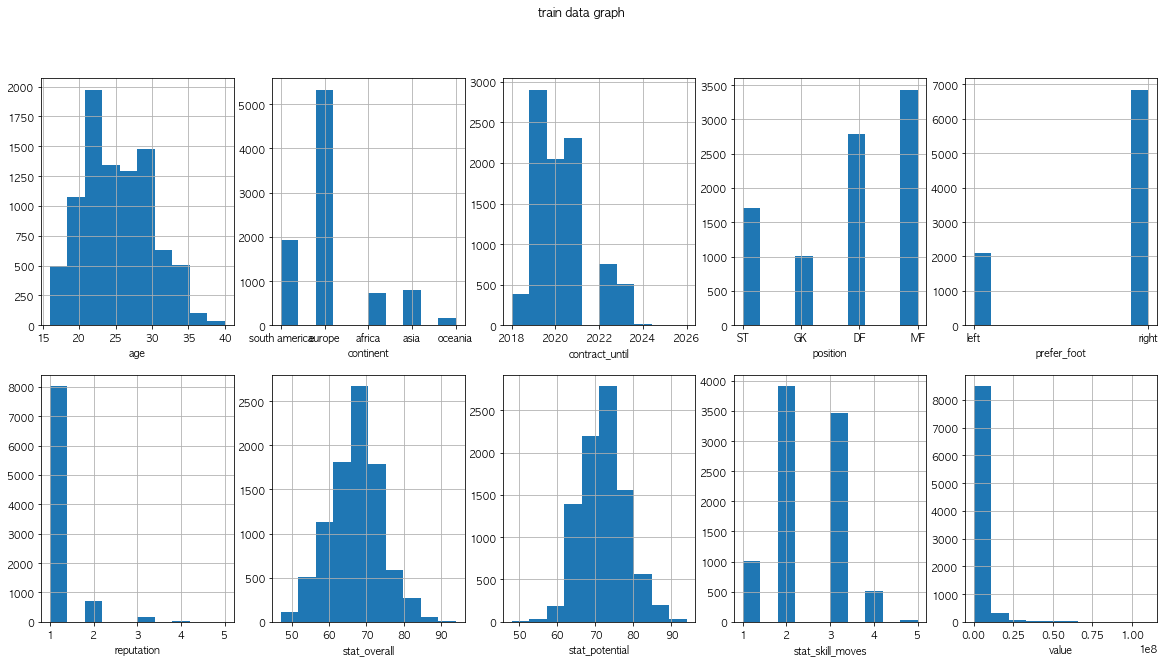

In [38]:
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.flatten()
col = train.columns
for i in range(len(train.columns)):
    train[col[i]].hist(ax=ax[i])
    ax[i].set_xlabel(col[i])
plt.suptitle('train data graph')    
plt.show()

* value가 왼쪽으로 많이 몰려있습니다.
* log를 통해 정규분포 형태로 만드는게 좋아 보입니다.

### 테스트 데이터 변수의 시각화

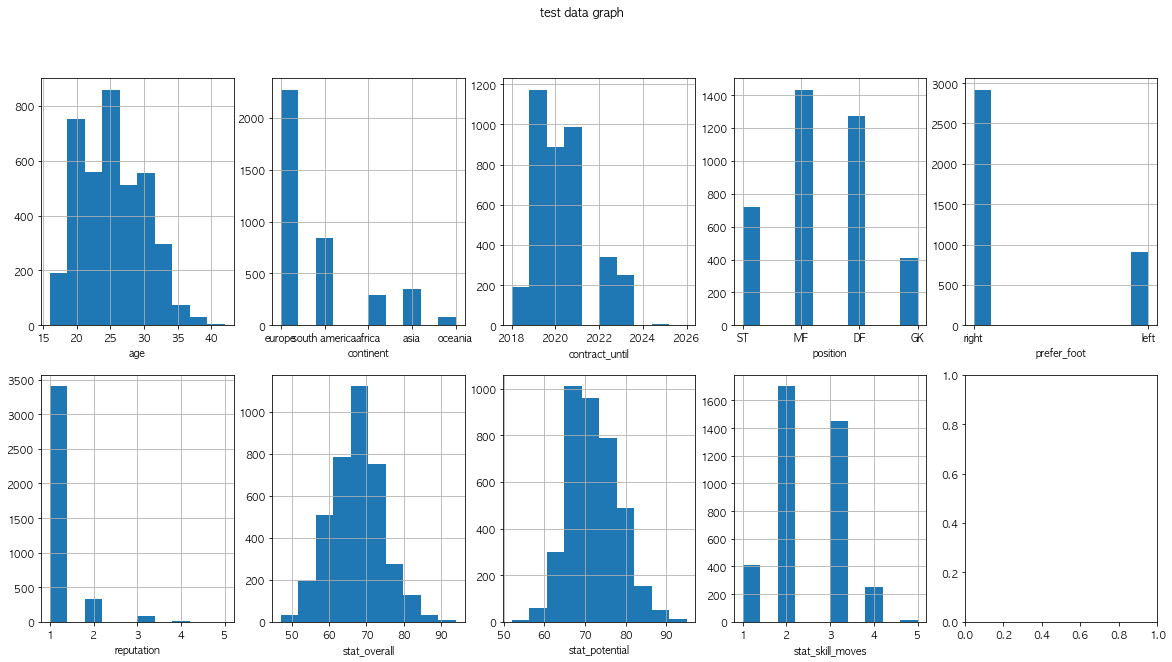

In [39]:
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.flatten()
col = test.columns
for i in range(len(test.columns)):
    test[col[i]].hist(ax=ax[i])
    ax[i].set_xlabel(col[i])
plt.suptitle('test data graph')    
plt.show()

* 나이의 분포는 10대후반 부터 20대후반까지 모여있습니다.
* 유럽 대륙의 선수가 가장 많습니다.
* 2021년까지 계약이 된 선수들이 많습니다.
* 포지션별로 선수의 수가 차이를 보입니다.
* 오른발 선수가 왼발 선수보다 많습니다.
* 명성도는 1에 많이 몰려있습니다.
* 선수 능력치는 정규분포를 띄는것 같아 보이지만 실제로 확인이 필요합니다.
* 스킬 능력치는 2,3에 많이 분포되어 있습니다.

* 왜도 구하기

In [40]:
print(skew(train[['age','stat_overall','stat_potential','value']]))
print(skew(test[['age','stat_overall','stat_potential']]))

[0.35676403 0.02671861 0.28585745 5.88480973]
[0.3647638  0.13449001 0.32478698]


* value : 왜도가 3 이상  
* log를 통해 정규성 확보

* log 함수 사용 전 정규성 검정

QQ-Plot

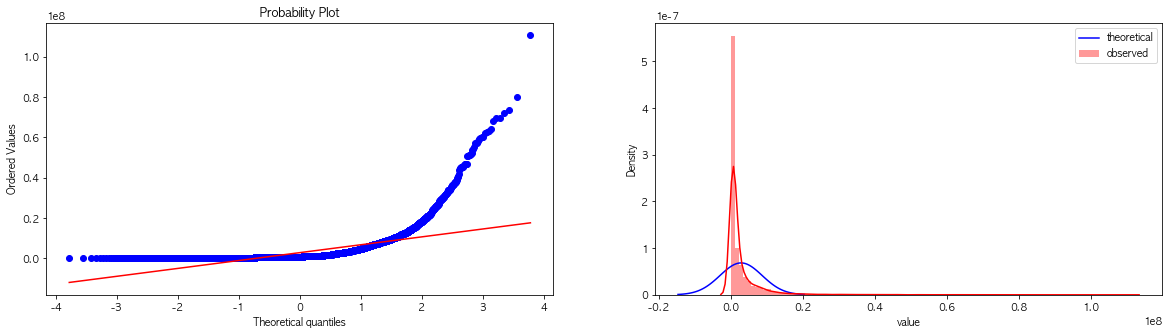

In [41]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train['value'],dist=stats.norm, plot=ax1)

mu = train['value'].mean()
var = train['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')

sns.distplot(ax=ax2, a=train['value'], bins=100, color = 'red', label='observed')
plt.rc('axes', unicode_minus=False)
ax2.legend()

plt.show()

#### log함수 적용

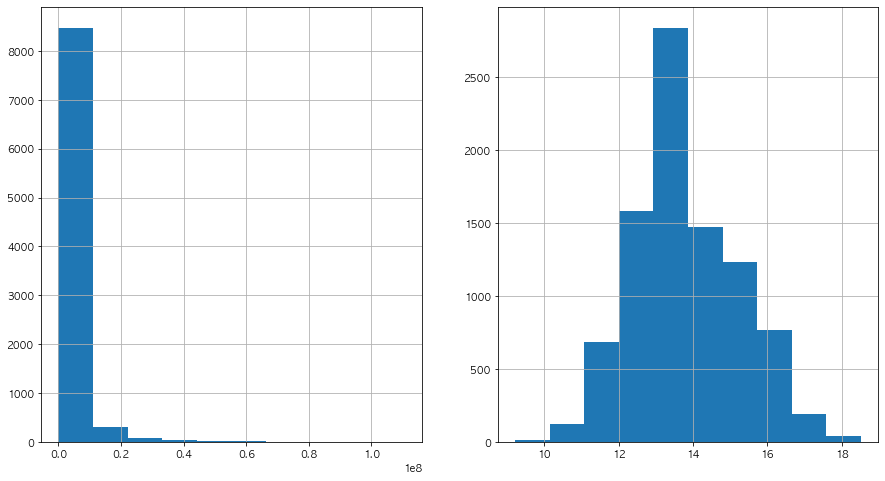

In [42]:
train_copy = train.copy()
test_copy = test.copy()

fig, ax = plt.subplots(1,2, figsize=(15,8))
ax = ax.flatten()

train_copy['value'].hist(ax=ax[0])
np.log1p(train_copy['value']).hist(ax=ax[1])
plt.show()

In [43]:
# value에 log를 이용하여 정규성 확보
train_copy['value'] = np.log1p(train_copy['value'])

* log함수 적용 후 정규성 검정

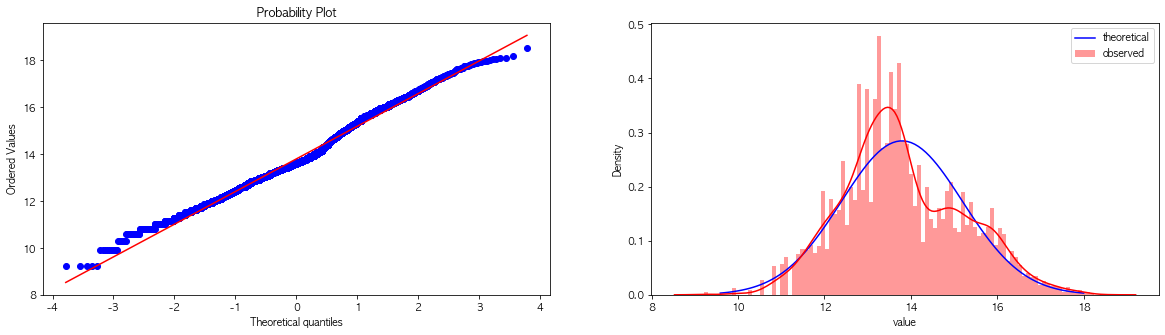

In [44]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train_copy['value'],dist=stats.norm, plot=ax1)

mu = train_copy['value'].mean()
var = train_copy['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')

sns.distplot(ax=ax2, a=train_copy['value'], bins=100, color = 'red', label='observed')
plt.rc('axes', unicode_minus=False)
ax2.legend()

plt.show()

* 학습용 데이터 value에 따른 그래프

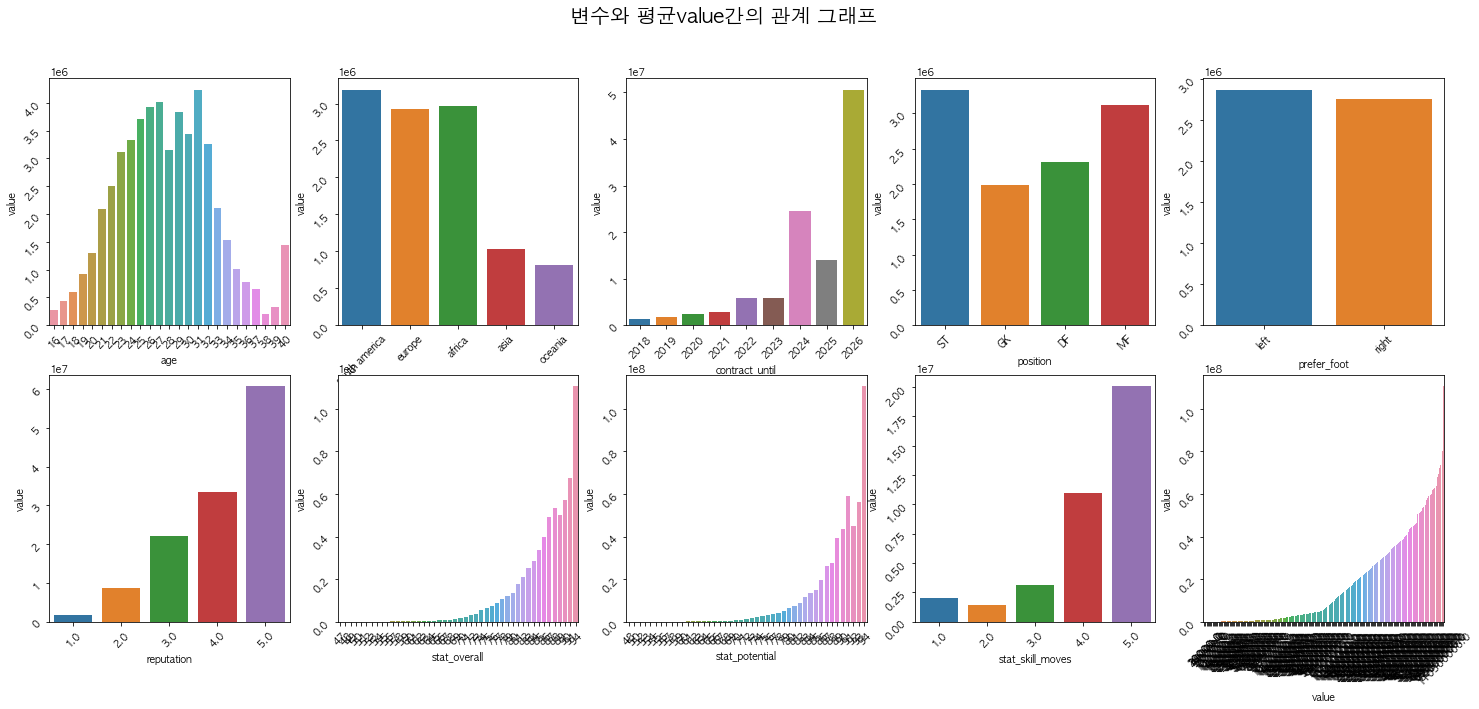

In [45]:
fig, ax = plt.subplots(2,5, figsize=(25,10))
ax = ax.flatten()
col = train.columns
for i in range(len(train.columns)):
    sns.barplot(x=train[col[i]],y=train['value'],ci=0,ax=ax[i])
    ax[i].set_xlabel(col[i])
    ax[i].tick_params(labelrotation=45)
plt.suptitle('변수와 평균value간의 관계 그래프',fontsize=20)    
plt.show()

* 28세와 40세에서 value값이 특이합니다. 확인을 해봐야 할 것 같습니다.
* 다른 대륙들보다 아시아, 오세아니아에서의 평균 value가 낮습니다.
* 2026년까지 계약한 선수의 평균이 눈에 띄게 높습니다.
* 포지션별로 value의 평균이 차이를 보입니다.
* 선호하는 발은 차이가 없어 보입니다.
* 명성도가 올라갈수록 value도 올라갑니다.
* 능력치가 올라갈수록 value도 올라갑니다.
* 스킬 능력치의 평균 value도 눈에 띄게 차이가 나기 때문에 확인이 필요합니다.

##### 40세에서 value가 높은 변수 확인

In [46]:
train[train['age']==40]

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
23,40,europe,2019,GK,right,4.0,88,88,1.0,4000000.0
1613,40,south america,2019,GK,right,1.0,73,73,1.0,270000.0
5168,40,south america,2021,GK,right,1.0,66,66,1.0,40000.0


##### 28살에서 value의 평균이 왜 낮아졌을까

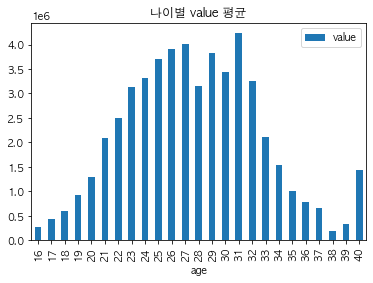

In [47]:
DataFrame(train.groupby('age')['value'].agg('mean')).sort_values(by='age').plot(kind='bar')
plt.title('나이별 value 평균')
plt.show()

* 나이별 value 최대값

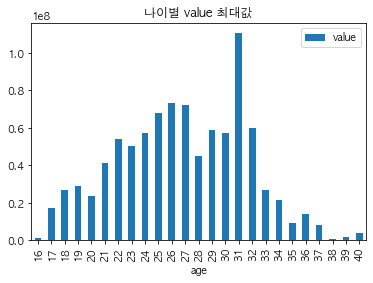

In [48]:
DataFrame(train.groupby('age')['value'].agg('max')).sort_values(by='age').plot(kind='bar')
plt.title('나이별 value 최대값')
plt.show()

28세에서 최대값이 많이 낮습니다.

In [49]:
DataFrame(train['age'].value_counts().sort_index()).T

,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
age,18,131,344,491,582,676,632,663,691,654,708,581,532,472,476,347,285,202,216,89,64,42,17,16,3


혹시나 싶어 나이별 인원 수를 확인해보니 28세에 인원수가 많이 떨어지는건 아닌 것 같습니다.

* 28세와 28세가 아닌 선수들의 데이터 분포 그래프

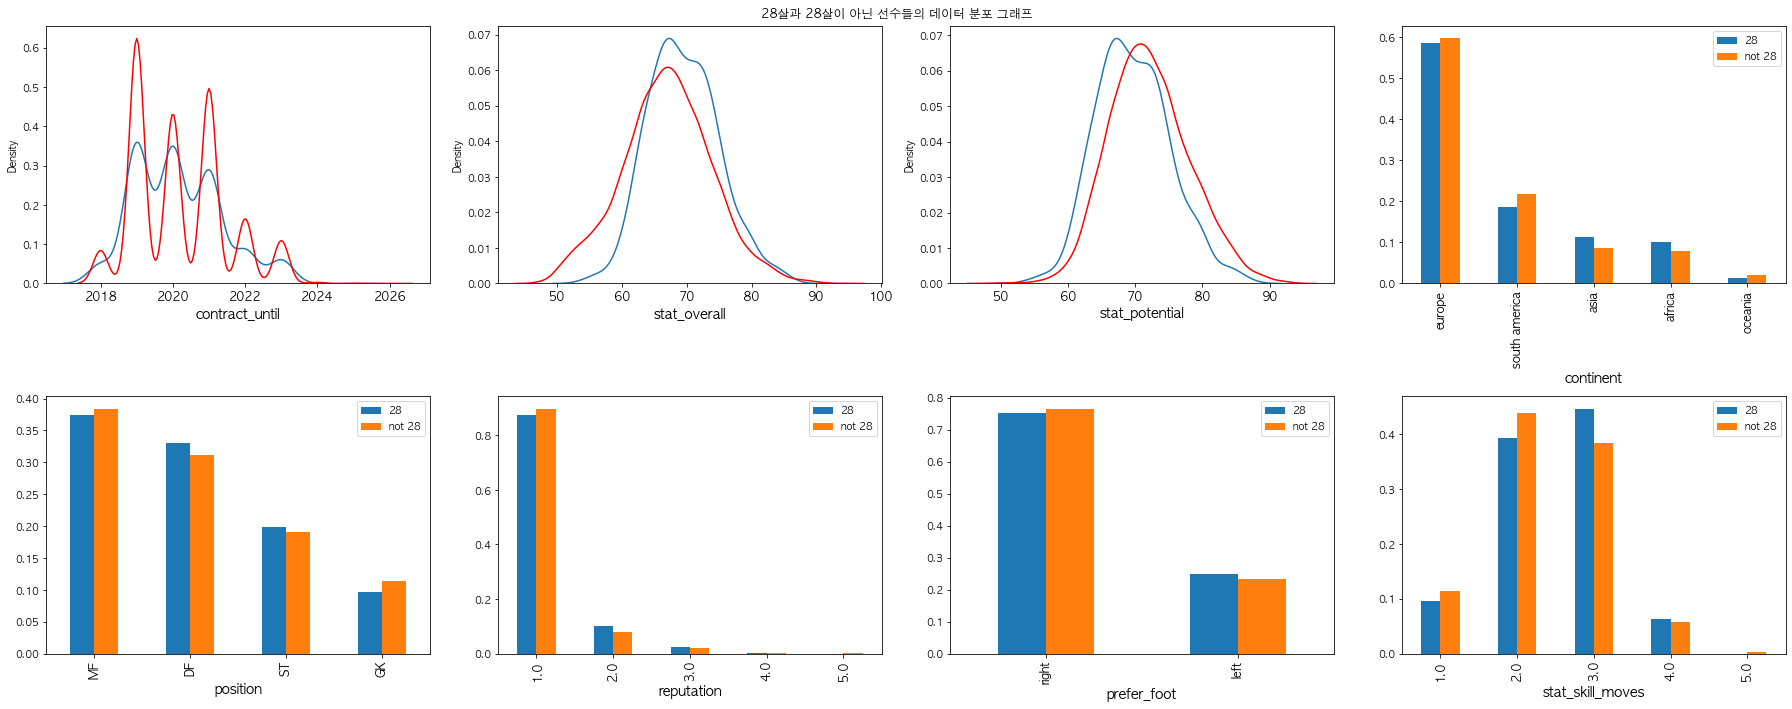

In [50]:
fig, ax = plt.subplots(2,4, figsize=(25,10))
ax = ax.flatten()
col = ['contract_until','stat_overall','stat_potential','continent','position','reputation','prefer_foot','stat_skill_moves']
for i in range(len(col)):
    if i < 3:
        sns.distplot(train_copy[train_copy['age']==28][col[i]],kde=True,hist=False,hist_kws=({'alpha':1}),label='28',ax=ax[i])
        sns.distplot(train_copy[train_copy['age']!=28][col[i]],kde=True,hist=False,kde_kws=({'color':'red'}),label='not 28',ax=ax[i])
        ax[i].set_xlabel(col[i],fontsize=14)
        ax[i].tick_params(axis = 'x', labelsize =12)

    else:
        
        train_28 = pd.DataFrame(train_copy[train_copy['age']==28][col[i]].value_counts() / len(train_copy[train_copy['age']==28]))
        train_28.rename(columns={col[i]:'28'},inplace=True)

        train_not28 = pd.DataFrame(train_copy[train_copy['age']!=28][col[i]].value_counts() / len(train_copy[train_copy['age']!=28]))
        train_not28.rename(columns={col[i]:'not 28'},inplace=True)

        pd.concat([train_28,train_not28],axis=1).plot(kind='bar',ax=ax[i])
        ax[i].set_xlabel(col[i],fontsize=14)
        ax[i].tick_params(axis = 'x', labelsize =12)
    
plt.suptitle('28살과 28살이 아닌 선수들의 데이터 분포 그래프')    
plt.legend()
plt.tight_layout()
plt.show()

* 28세인 선수와 28세가 아닌 선수의 데이터 분포는 차이가 없습니다.
* 28세 선수 중 많은 value를 받는 선수가 없어서 평균값이 낮게 나오는 것 같습니다.

#### 대륙별 value 최소, 최대, 평균, 선수 인원 합

In [51]:
# 대륙별 value 최소,최대,평균, 선수 인원 합
train.groupby('continent')['value'].agg(['min','max','mean','size'])

,min,max,mean,size
continent,,,,
africa,20000.0,69500000.0,2.972247e+06,721
asia,10000.0,14500000.0,1.035146e+06,787
europe,10000.0,73500000.0,2.928125e+06,5322
oceania,30000.0,10500000.0,8.225429e+05,175
south america,20000.0,110500000.0,3.183204e+06,1927


### 대륙별 value의 평균의 차이가 있을까?

#### ANOVA분석  
* 서로 다른 그룹의 평균을 비교하는 분석
* 평균의 차이가 유의미한지 확인
* 종속 변수의 정규성 확보가 필요하다.

### 대륙별 value의 정규성 검정

변수에 log를 취하고 진행

* europe - value

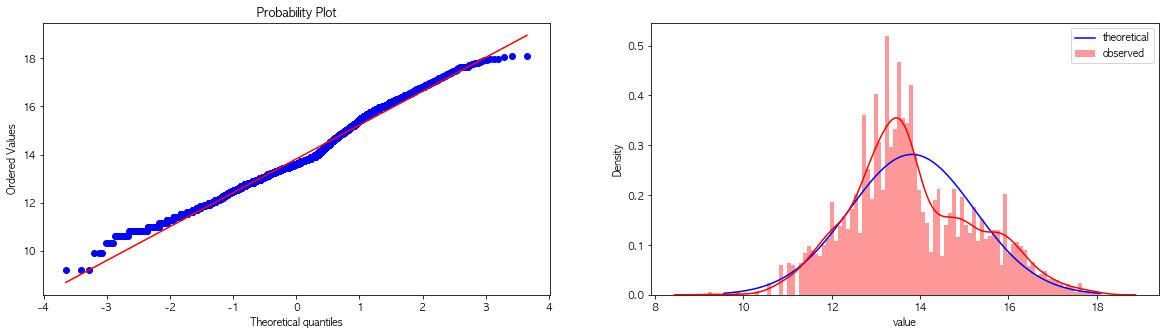

In [52]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train_copy[train_copy['continent']=='europe']['value'],dist=stats.norm, plot=ax1)

mu = train_copy[train_copy['continent']=='europe']['value'].mean()
var = train_copy[train_copy['continent']=='europe']['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')
plt.rc('axes', unicode_minus=False)

sns.distplot(ax=ax2, a=train_copy[train_copy['continent']=='europe']['value'], bins=100, color = 'red', label='observed')
ax2.legend()

plt.show()

* south america - value

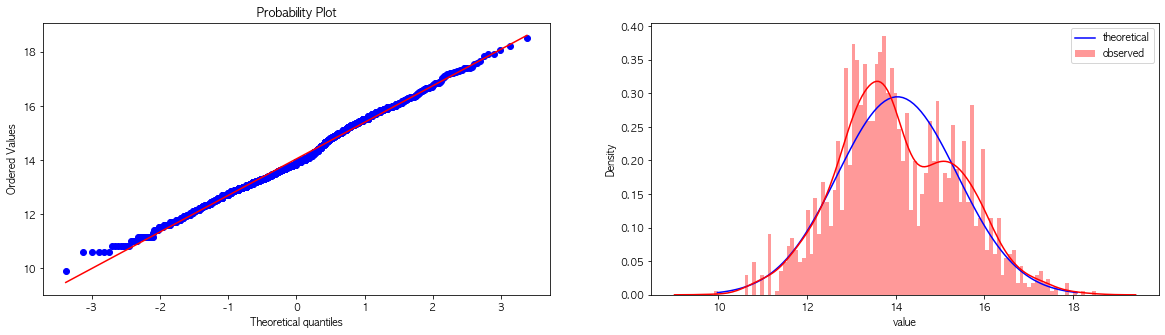

In [53]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train_copy[train_copy['continent']=='south america']['value'],dist=stats.norm, plot=ax1)

mu = train_copy[train_copy['continent']=='south america']['value'].mean()
var = train_copy[train_copy['continent']=='south america']['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')
plt.rc('axes', unicode_minus=False)

sns.distplot(ax=ax2, a=train_copy[train_copy['continent']=='south america']['value'], bins=100, color = 'red', label='observed')
ax2.legend()

plt.show()

* africa - value

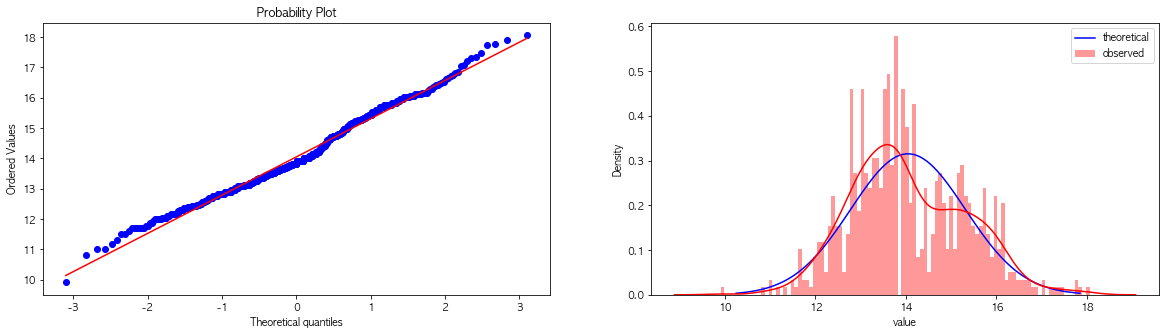

In [54]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train_copy[train_copy['continent']=='africa']['value'],dist=stats.norm, plot=ax1)

mu = train_copy[train_copy['continent']=='africa']['value'].mean()
var = train_copy[train_copy['continent']=='africa']['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')
plt.rc('axes', unicode_minus=False)

sns.distplot(ax=ax2, a=train_copy[train_copy['continent']=='africa']['value'], bins=100, color = 'red', label='observed')
ax2.legend()

plt.show()

* asia - value

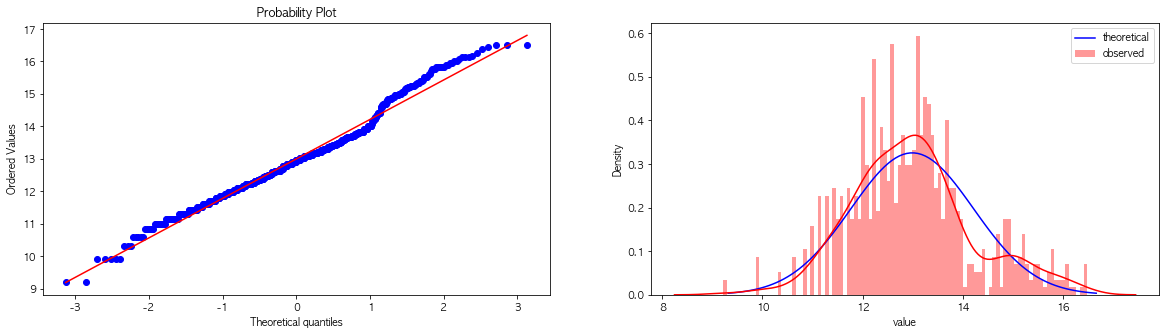

In [55]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train_copy[train_copy['continent']=='asia']['value'],dist=stats.norm, plot=ax1)

mu = train_copy[train_copy['continent']=='asia']['value'].mean()
var = train_copy[train_copy['continent']=='asia']['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')
plt.rc('axes', unicode_minus=False)

sns.distplot(ax=ax2, a=train_copy[train_copy['continent']=='asia']['value'], bins=100, color = 'red', label='observed')
ax2.legend()

plt.show()

* oceania - value

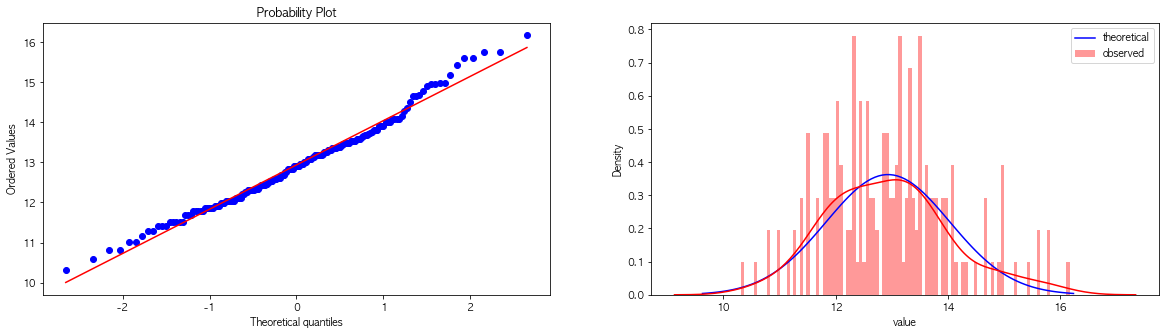

In [56]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train_copy[train_copy['continent']=='oceania']['value'],dist=stats.norm, plot=ax1)

mu = train_copy[train_copy['continent']=='oceania']['value'].mean()
var = train_copy[train_copy['continent']=='oceania']['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')
plt.rc('axes', unicode_minus=False)

sns.distplot(ax=ax2, a=train_copy[train_copy['continent']=='oceania']['value'], bins=100, color = 'red', label='observed')
ax2.legend()

plt.show()

### 대륙별 value의 ANOVA분석

In [57]:
# 대륙별 value, ANOVA
model = ols('value ~ C(continent)', train).fit()
print(anova_lm(model))

                  df        sum_sq       mean_sq          F        PR(>F)
C(continent)     4.0  3.523251e+15  8.808128e+14  26.107688  1.499155e-21
Residual      8927.0  3.011763e+17  3.373768e+13        NaN           NaN


* P-value값이 0.05 보다 작으므로 대륙별 value의 평균에는 차이가 존재한다

---

### 포지션별 value의 평균 차이

* ST - value

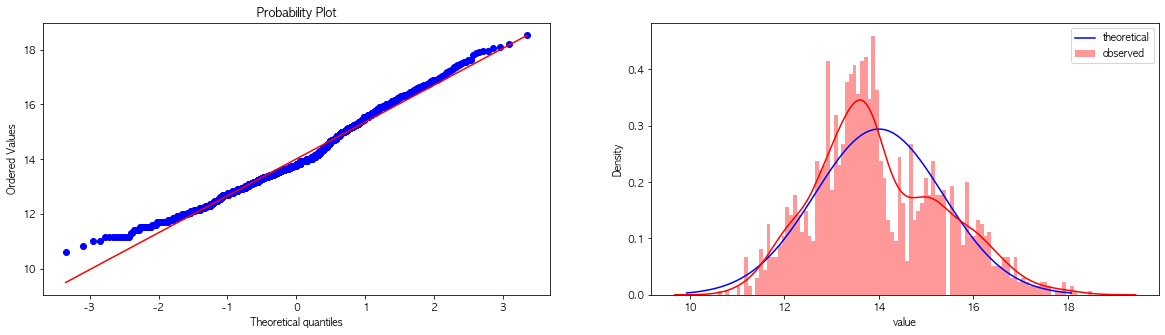

In [58]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train_copy[train_copy['position']=='ST']['value'],dist=stats.norm, plot=ax1)

mu = train_copy[train_copy['position']=='ST']['value'].mean()
var = train_copy[train_copy['position']=='ST']['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')
plt.rc('axes', unicode_minus=False)

sns.distplot(ax=ax2, a=train_copy[train_copy['position']=='ST']['value'], bins=100, color = 'red', label='observed')
ax2.legend()

plt.show()

* MF - value

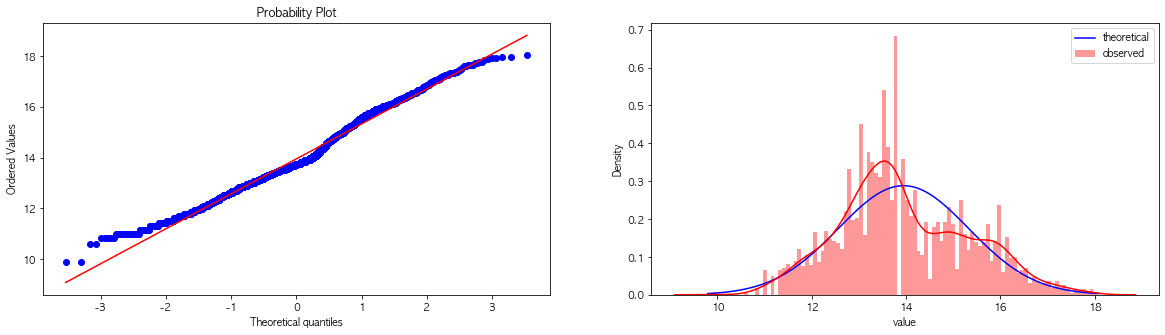

In [59]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train_copy[train_copy['position']=='MF']['value'],dist=stats.norm, plot=ax1)

mu = train_copy[train_copy['position']=='MF']['value'].mean()
var = train_copy[train_copy['position']=='MF']['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')
plt.rc('axes', unicode_minus=False)

sns.distplot(ax=ax2, a=train_copy[train_copy['position']=='MF']['value'], bins=100, color = 'red', label='observed')
ax2.legend()

plt.show()

* DF - value

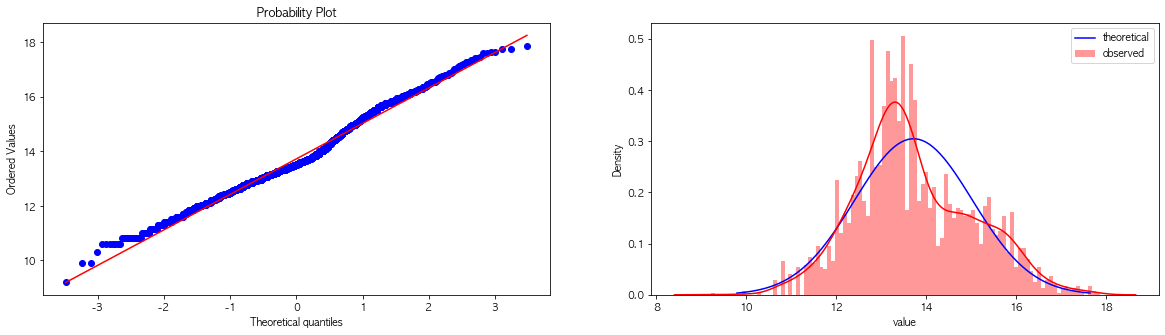

In [60]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train_copy[train_copy['position']=='DF']['value'],dist=stats.norm, plot=ax1)

mu = train_copy[train_copy['position']=='DF']['value'].mean()
var = train_copy[train_copy['position']=='DF']['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')
plt.rc('axes', unicode_minus=False)

sns.distplot(ax=ax2, a=train_copy[train_copy['position']=='DF']['value'], bins=100, color = 'red', label='observed')
ax2.legend()

plt.show()

* GK - value

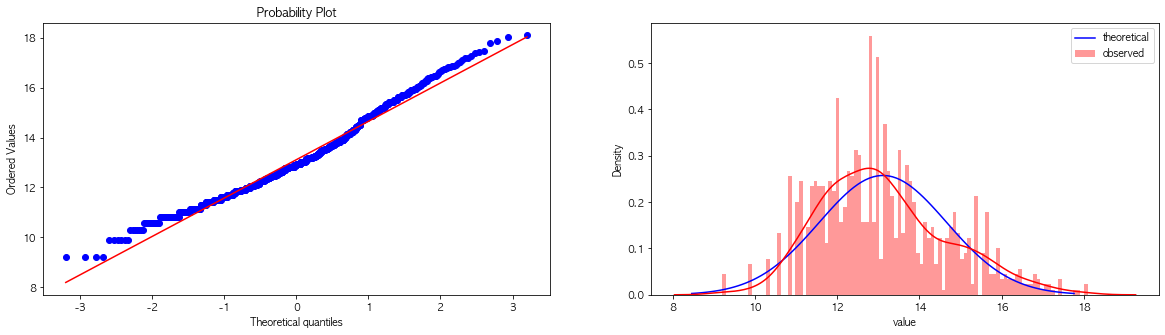

In [61]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train_copy[train_copy['position']=='GK']['value'],dist=stats.norm, plot=ax1)

mu = train_copy[train_copy['position']=='GK']['value'].mean()
var = train_copy[train_copy['position']=='GK']['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')
plt.rc('axes', unicode_minus=False)

sns.distplot(ax=ax2, a=train_copy[train_copy['position']=='GK']['value'], bins=100, color = 'red', label='observed')
ax2.legend()

plt.show()

* 포지션별 vlaue의 ANOVA분석

In [62]:
# 포지션별 value, ANOVA
model = ols('value ~ C(position)', train).fit()
print(anova_lm(model))

                 df        sum_sq       mean_sq          F        PR(>F)
C(position)     3.0  2.174063e+15  7.246875e+14  21.386665  8.478638e-14
Residual     8928.0  3.025254e+17  3.388502e+13        NaN           NaN


* P-value값이 0.05 보다 작으므로 포지션별 value의 평균에는 차이가 존재한다

---

### 선호하는 발에 따른 value의 평균 차이

#### 선호하는 발에 따른 value의 정규성 검정

* right - value

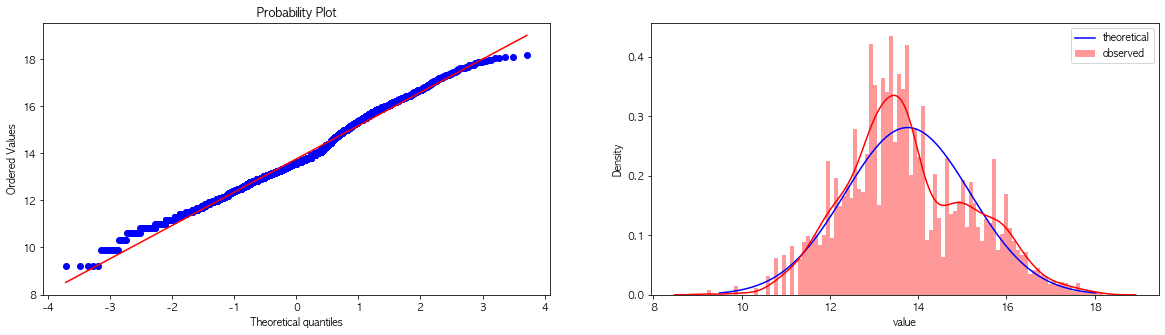

In [63]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train_copy[train_copy['prefer_foot']=='right']['value'],dist=stats.norm, plot=ax1)

mu = train_copy[train_copy['prefer_foot']=='right']['value'].mean()
var = train_copy[train_copy['prefer_foot']=='right']['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')
plt.rc('axes', unicode_minus=False)

sns.distplot(ax=ax2, a=train_copy[train_copy['prefer_foot']=='right']['value'], bins=100, color = 'red', label='observed')
ax2.legend()

plt.show()

* left - value

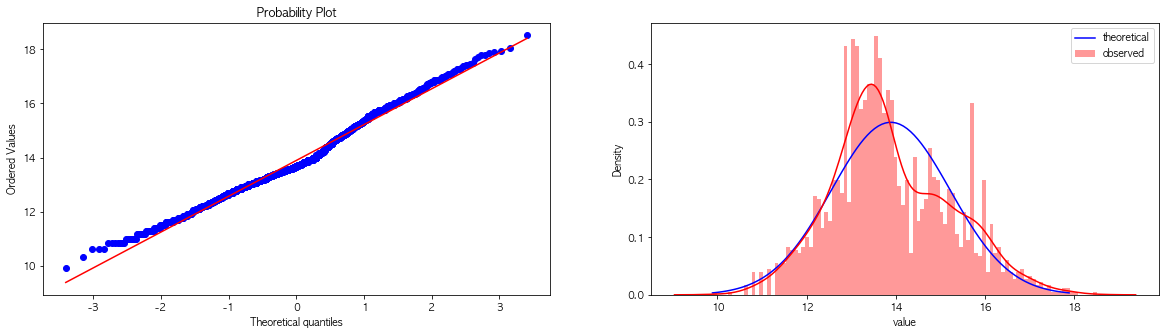

In [64]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train_copy[train_copy['prefer_foot']=='left']['value'],dist=stats.norm, plot=ax1)

mu = train_copy[train_copy['prefer_foot']=='left']['value'].mean()
var = train_copy[train_copy['prefer_foot']=='left']['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')
plt.rc('axes', unicode_minus=False)

sns.distplot(ax=ax2, a=train_copy[train_copy['prefer_foot']=='left']['value'], bins=100, color = 'red', label='observed')
ax2.legend()

plt.show()

* 선호하는 발에 따른 value의 ANOVA 분석

In [65]:
# 선호하는 발에 따른 value, ANOVA
model = ols('value ~ C(prefer_foot)', train).fit()
print(anova_lm(model))
# 평균의 차이가 없다

                    df        sum_sq       mean_sq         F    PR(>F)
C(prefer_foot)     1.0  2.050612e+13  2.050612e+13  0.601025  0.438208
Residual        8930.0  3.046790e+17  3.411859e+13       NaN       NaN


* p-value가 0.05를 넘기때문에 귀무가설 기각
* 선호하는 발과 value에는 차이가 없다

---

### 포지션별 대륙의 비율

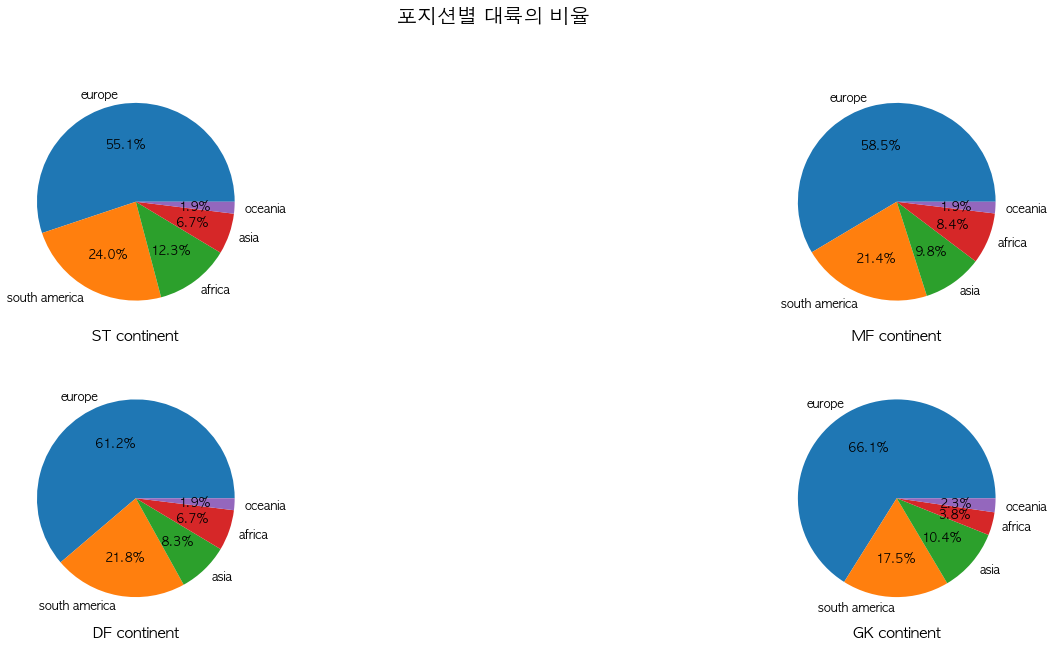

In [66]:
fig, ax = plt.subplots(2,2, figsize=(25,10))
ax = ax.flatten()
labels = ['europe','south america','africa', 'asia', 'oceania']    
ax[0].pie(train[train['position']=='ST']['continent'].value_counts() / len(train[train['position']=='ST']),
       labels=(train[train['position']=='ST']['continent'].value_counts() / len(train[train['position']=='ST'])).index,autopct='%.1f%%',textprops={'size':12})
ax[0].set_xlabel('ST continent',fontsize=15)

ax[1].pie(train[train['position']=='MF']['continent'].value_counts() / len(train[train['position']=='MF']),
       labels=(train[train['position']=='MF']['continent'].value_counts() / len(train[train['position']=='MF'])).index,autopct='%.1f%%',textprops={'size':12})
ax[1].set_xlabel('MF continent',fontsize=15)

ax[2].pie(train[train['position']=='DF']['continent'].value_counts() / len(train[train['position']=='DF']),
       labels=(train[train['position']=='DF']['continent'].value_counts() / len(train[train['position']=='DF'])).index,autopct='%.1f%%',textprops={'size':12},normalize=False)
ax[2].set_xlabel('DF continent',fontsize=15)

ax[3].pie(train[train['position']=='GK']['continent'].value_counts() / len(train[train['position']=='GK']),
       labels=(train[train['position']=='GK']['continent'].value_counts() / len(train[train['position']=='GK'])).index,autopct='%.1f%%',textprops={'size':12},normalize=False)
ax[3].set_xlabel('GK continent',fontsize=15)
plt.suptitle('포지션별 대륙의 비율',fontsize=20) 
plt.show()

* 유럽선수는 모수가 많기 때문에 많은 비율을 차지한다.
* ST에는 아시아 선수보다 아프리카 선수가 더 많다.
* MF,DF,GK는 유럽, 남아메리카 다음으로 아시아 출신 선수가 많다.

### 대륙별 포지션의 비율

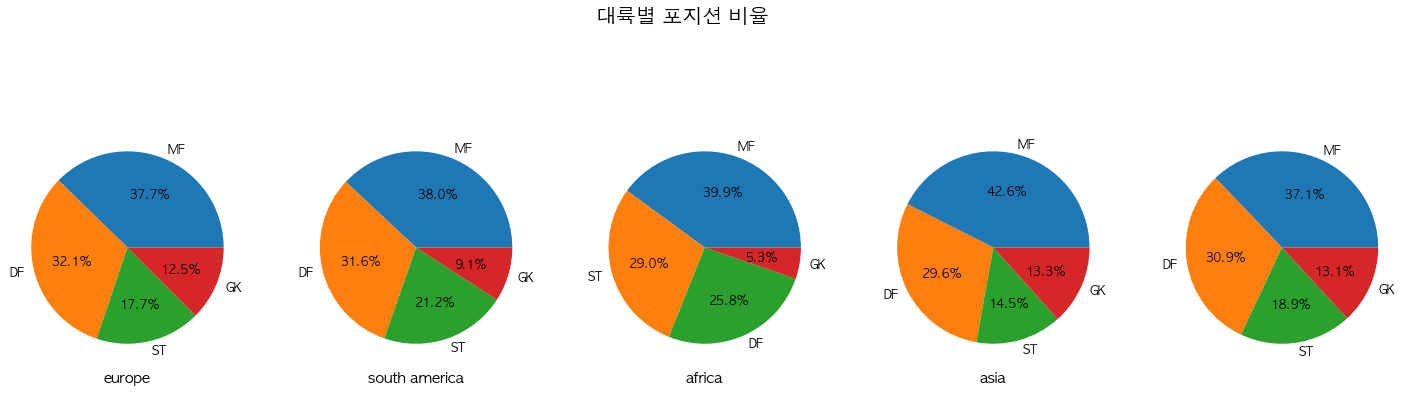

In [67]:
fig, ax = plt.subplots(1,5, figsize=(25,7))
ax = ax.flatten()
    
ax[0].pie(train[train['continent']=='europe']['position'].value_counts() / len(train[train['continent']=='europe']),
       labels=(train[train['continent']=='europe']['position'].value_counts() / len(train[train['continent']=='europe'])).index,autopct='%.1f%%',textprops={'size':12},normalize=False)
ax[0].set_xlabel('europe',fontsize=15)

ax[1].pie(train[train['continent']=='south america']['position'].value_counts() / len(train[train['continent']=='south america']),
       labels=(train[train['continent']=='south america']['position'].value_counts() / len(train[train['continent']=='south america'])).index,autopct='%.1f%%',textprops={'size':12})
ax[1].set_xlabel('south america',fontsize=15)

ax[2].pie(train[train['continent']=='africa']['position'].value_counts() / len(train[train['continent']=='africa']),
       labels=(train[train['continent']=='africa']['position'].value_counts() / len(train[train['continent']=='africa'])).index,autopct='%.1f%%',textprops={'size':12})
ax[2].set_xlabel('africa',fontsize=15)

ax[3].pie(train[train['continent']=='asia']['position'].value_counts() / len(train[train['continent']=='asia']),
       labels=(train[train['continent']=='asia']['position'].value_counts() / len(train[train['continent']=='asia'])).index,autopct='%.1f%%',textprops={'size':12})
ax[3].set_xlabel('asia',fontsize=15)

ax[4].pie(train[train['continent']=='oceania']['position'].value_counts() / len(train[train['continent']=='oceania']),
       labels=(train[train['continent']=='oceania']['position'].value_counts() / len(train[train['continent']=='oceania'])).index,autopct='%.1f%%',textprops={'size':12})
ax[4].set_xlabel('oceania',fontsize=15,color='white')
plt.suptitle('대륙별 포지션 비율',fontsize=20) 
plt.show()

* 모든 대륙에서 MF 선수가 제일 많다.
* 아프리카 대륙에서만 ST가 두 번째로 많다.
* 아프라키 대륙에서만 GK가 5% 비율로 눈에 띄게 적다.
* 아프리카 대륙을 제외한 대륙에서는 MF,DF,ST,GK 순으로 선수가 많다.

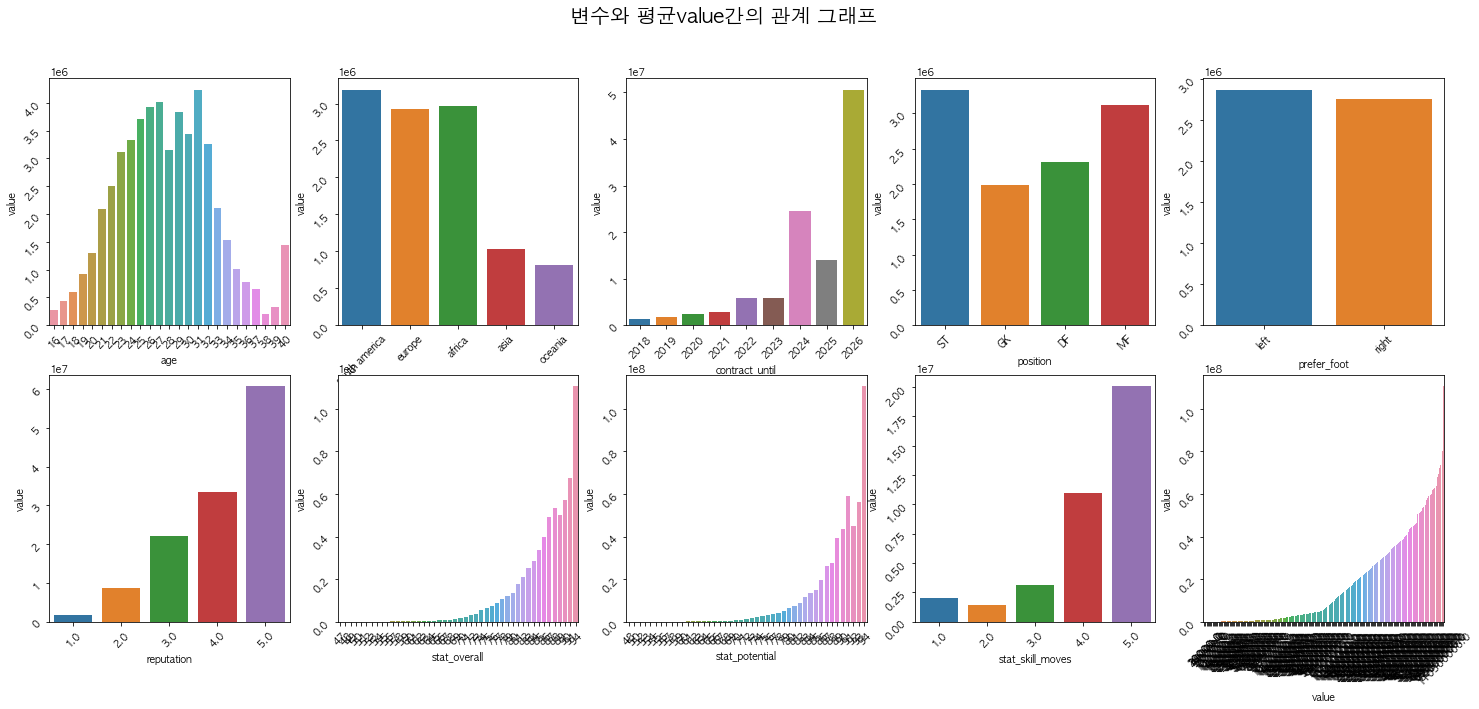

In [68]:
fig, ax = plt.subplots(2,5, figsize=(25,10))
ax = ax.flatten()
col = train.columns
for i in range(len(train.columns)):
    sns.barplot(x=train[col[i]],y=train['value'],ci=0,ax=ax[i])
    ax[i].set_xlabel(col[i])
    ax[i].tick_params(labelrotation=45)
plt.suptitle('변수와 평균value간의 관계 그래프',fontsize=20)    
plt.show()

* 계약기간이 2026년인 선수들의 평균 value가 눈에 띄게 높습니다.

#### 계약기간이 2026년까지인 선수

In [69]:
train[train['contract_until']==2026]

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
48,23,europe,2026,MF,left,3.0,85,90,3.0,50500000.0


* 계약기간이 2026년까지인 선수는 한 명이라 그래프에서 높은 값을 보인 것 같습니다.

#### 계약기간이 2025년까지인 선수

In [70]:
train[train['contract_until']==2025]

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
202,24,europe,2025,ST,right,2.0,81,87,4.0,24500000.0
672,17,south america,2025,ST,right,1.0,77,92,5.0,17500000.0
8496,18,europe,2025,DF,left,1.0,55,73,2.0,160000.0


#### 계약기간이 2024년까지인 선수

In [71]:
train[train['contract_until']==2024]

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
9,26,europe,2024,GK,left,4.0,89,90,1.0,53500000.0
47,25,south america,2024,GK,right,3.0,85,90,1.0,36500000.0
66,22,south america,2024,DF,right,2.0,84,88,2.0,34000000.0
141,21,south america,2024,MF,right,1.0,82,90,4.0,32500000.0
145,21,europe,2024,MF,right,1.0,82,86,4.0,29000000.0
203,23,south america,2024,MF,right,1.0,81,87,4.0,24500000.0
253,22,europe,2024,DF,right,1.0,80,88,3.0,18500000.0
257,21,europe,2024,MF,left,1.0,80,87,3.0,21000000.0
259,21,africa,2024,MF,right,1.0,80,85,3.0,17000000.0
303,25,europe,2024,MF,right,2.0,80,83,4.0,18500000.0


* 계약기간이 2024, 2025년까지인 선수들은 인원은 적지만 전체 선수 중 상위권에 있는 선수가 많이 때문에 평균이 높게 나온 것 같습니다.
* 전체 8932명 중 상위 10%는 893명 입니다.

---

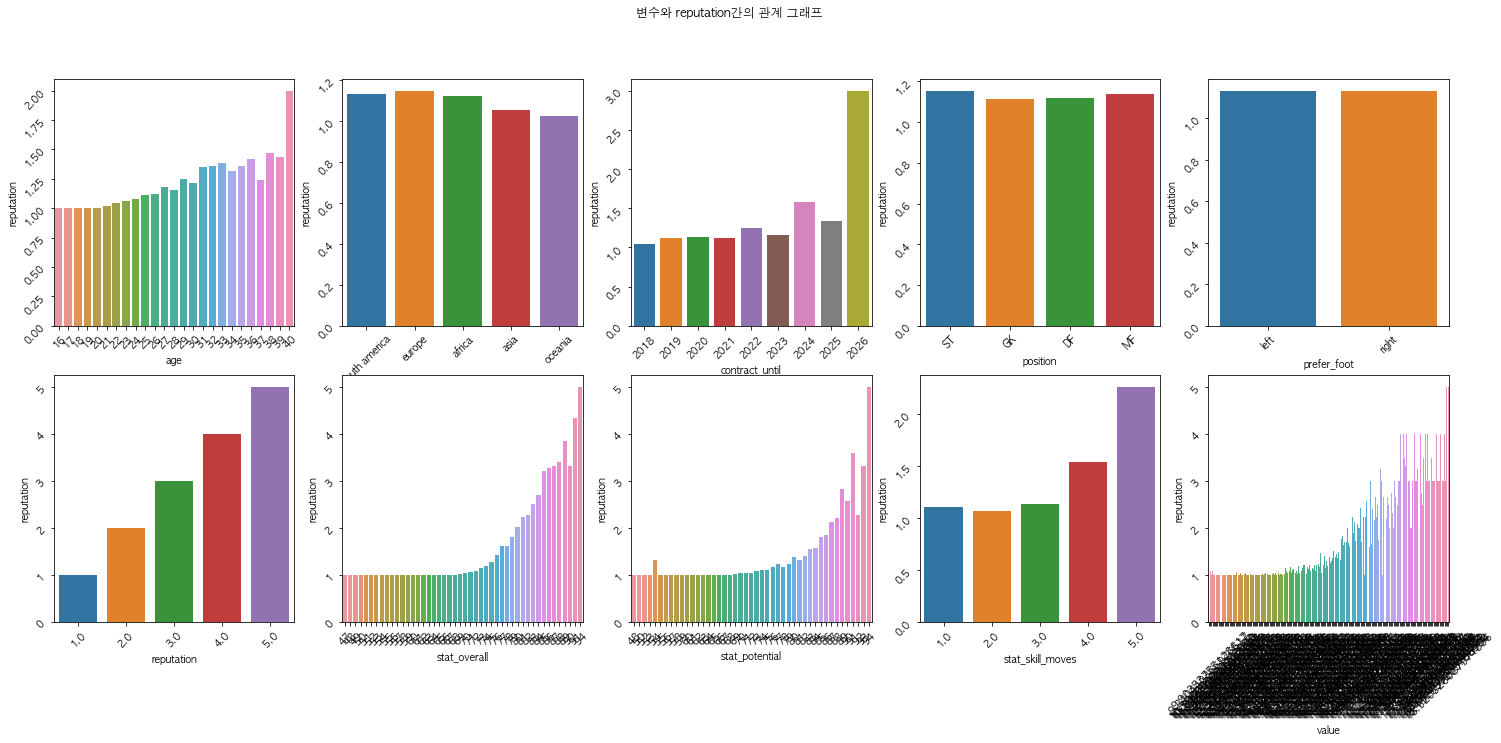

In [72]:
fig, ax = plt.subplots(2,5, figsize=(25,10))
ax = ax.flatten()
col = train_copy.columns
for i in range(len(train_copy.columns)):
    sns.barplot(x=train_copy[col[i]],y=train_copy['reputation'],ci=0,ax=ax[i])
    ax[i].set_xlabel(col[i])
    ax[i].tick_params(labelrotation=45)
plt.suptitle('변수와 reputation간의 관계 그래프')    
plt.show()

* stat_potential이 낮은데 평균 reputation이 높게 나온 구간이 보입니다.

In [73]:
train[train_copy['stat_potential']==54]

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
8612,28,asia,2021,ST,right,1.0,54,54,2.0,70000.0
8635,38,asia,2021,MF,right,2.0,54,54,3.0,20000.0
8689,29,europe,2019,DF,left,1.0,53,54,2.0,50000.0


* stat_potential이 54인 선수 3명 중 1명의 reputation이 2이기때문에 평균이 높게 나왔습니다.

# 학습용 데이터와 테스트 데이터의 변수 분포 확인

## 수치형 자료의 분포

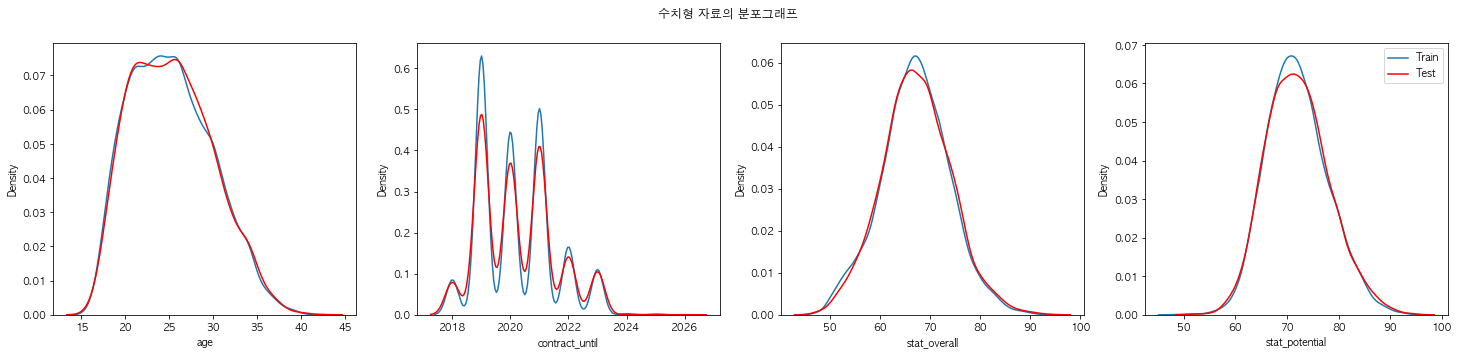

In [74]:
fig, ax = plt.subplots(1,4, figsize=(25,5))
ax = ax.flatten()
col = ['age','contract_until','stat_overall','stat_potential']
for i in range(len(col)):
    sns.distplot(train_copy[col[i]],kde=True,hist=False,hist_kws=({'alpha':1}),label='Train',ax=ax[i])
    sns.distplot(test_copy[col[i]],kde=True,hist=False,kde_kws=({'color':'red'}),label='Test',ax=ax[i])
    ax[i].set_xlabel(col[i])

plt.suptitle('수치형 자료의 분포그래프')    
plt.legend()
plt.show()

* train, test 수치형 자료의 분포는 거의 같습니다.

## 범주형 자료의 비율

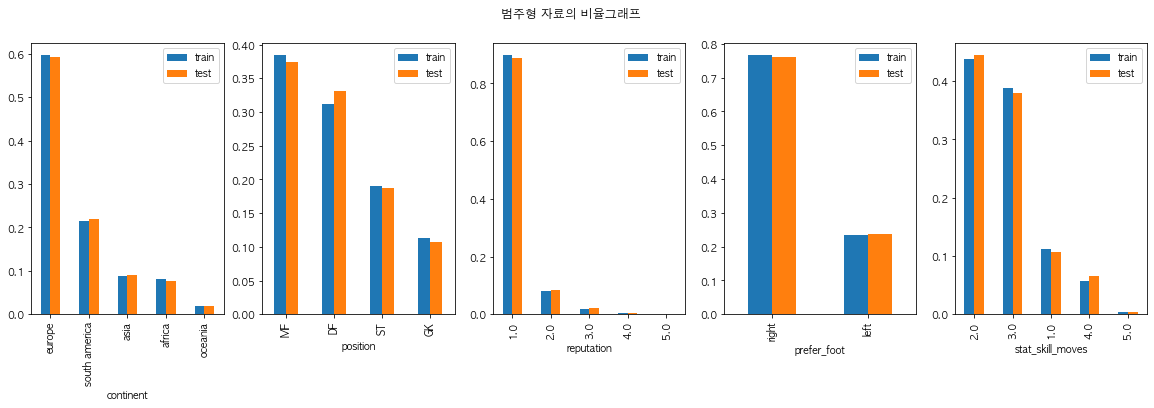

In [75]:
fig, ax = plt.subplots(1,5, figsize=(20,5))
ax = ax.flatten()
col = ['continent','position','reputation','prefer_foot','stat_skill_moves']
for i in range(len(col)):

    train_continent = pd.DataFrame(train_copy[col[i]].value_counts() / len(train_copy))
    train_continent.rename(columns={col[i]:'train'},inplace=True)

    test_continent = pd.DataFrame(test_copy[col[i]].value_counts() / len(test_copy))
    test_continent.rename(columns={col[i]:'test'},inplace=True)

    pd.concat([train_continent,test_continent],axis=1).plot(kind='bar',ax=ax[i])
    ax[i].set_xlabel(col[i])  
plt.suptitle('범주형 자료의 비율그래프')
plt.show()

* train, test 범주형 자료의 비율은 거의 같습니다.

---

#### 상관계수

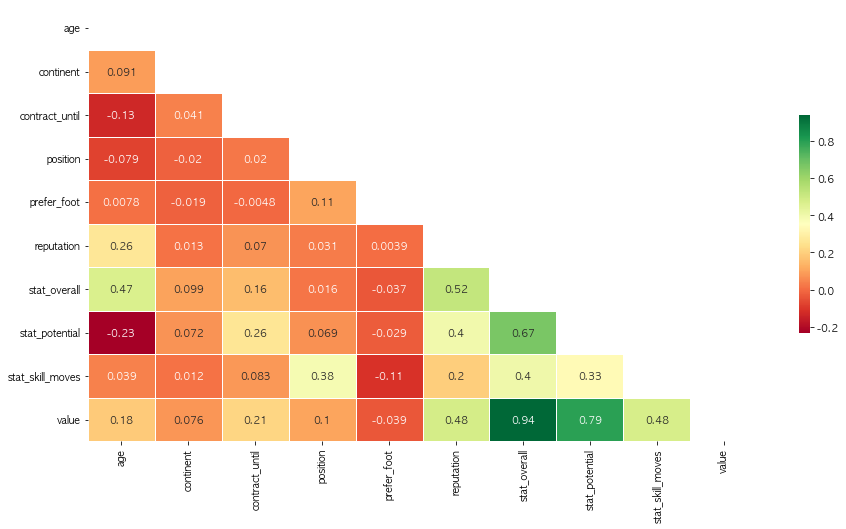

In [76]:
object_le = LabelEncoder()
train_copy[['continent','position','prefer_foot']] = train_copy[['continent','position','prefer_foot']].apply(object_le.fit_transform)

plt.figure(figsize=(15,8))
mask = np.zeros_like(train_copy.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_copy.corr(),cmap='RdYlGn',
            annot=True, # 실제값 표시
            mask=mask,  # 표시하지 않을 마스크 부분 지정
            linewidths=.5, # 경계면 실선 구분
            cbar_kws={'shrink':.5}) # 컬러바 절반으로 줄이기
            
plt.show()

* value와 reputation, stat_overall, stat_potential, stat_skill_moves는 양의 상관관계를 보입니다.
* 나이와 stat_overall은 양의 상관관계이지만, stat_potential은 음의 상관관계 입니다.
* stat_overall과 stat_potentail은 양의 상관관계이므로 나이와 stat_overall,potential을 살펴 봐야 할 것 같습니다.

#### 나이에 따른 stat_overall 비교

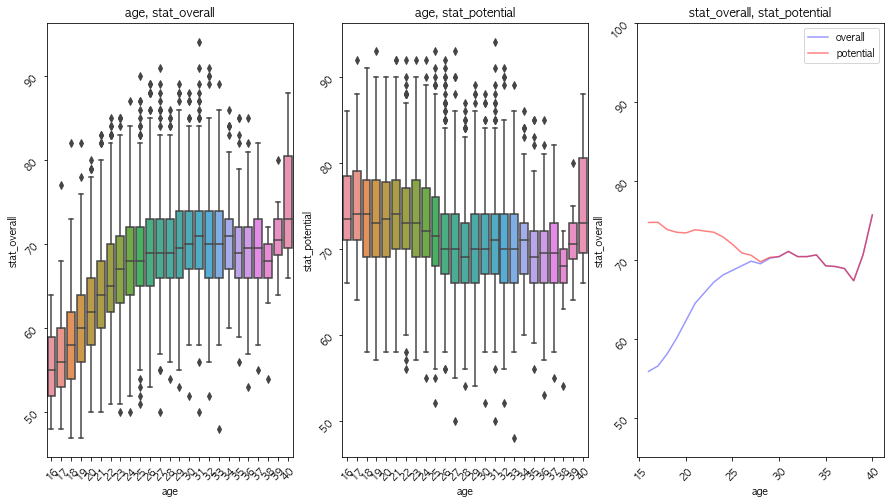

In [77]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
ax = ax.flatten()

sns.boxplot(train_copy['age'],train_copy['stat_overall'],ax=ax[0])
ax[0].set_title('age, stat_overall')
ax[0].tick_params(labelrotation=45)
plt.ylim(45,100)

sns.boxplot(train_copy['age'],train_copy['stat_potential'],ax=ax[1])
ax[1].set_title('age, stat_potential')
ax[1].tick_params(labelrotation=45)
plt.ylim(45,100)

sns.lineplot(train_copy['age'],train_copy['stat_overall'],ax=ax[2],label='overall',color='blue',ci=None,alpha=0.4)
sns.lineplot(train_copy['age'],train_copy['stat_potential'],ax=ax[2],label='potential',color='red',ci=None,alpha=0.5)
plt.ylim(45,100)
ax[2].set_title('stat_overall, stat_potential')
ax[2].tick_params(labelrotation=45)
plt.show()

* 나이에 따른 stat_overall,potential 그래프에서 그래프가 겹쳐 보입니다.

In [78]:
age_stat_ratio = round(train_copy[train_copy['stat_overall']==train_copy['stat_potential']]['age'].value_counts() / train_copy[train_copy['age']>=25]['age'].value_counts(),3) * 100

print('stat_overall과 stat_potential이 같은 비율')
DataFrame(age_stat_ratio).rename(columns={'age':'ratio'}).T

stat_overall과 stat_potential이 같은 비율


,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
ratio,0.3,22.3,50.4,82.5,90.9,99.6,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


* 일정 나이 이상이 되면 overall과 potential이 같아집니다.
* 나이가 올라갈수록 선수의 성장이 멈추는 것 같습니다.

---
#### value와의 상관계수

In [79]:
train_copy.drop('value',axis=1).corrwith(train['value']).sort_values()

prefer_foot        -0.008204
continent           0.039554
position            0.074980
age                 0.087319
contract_until      0.228638
stat_skill_moves    0.298500
stat_potential      0.611907
stat_overall        0.658444
reputation          0.665982
dtype: float64

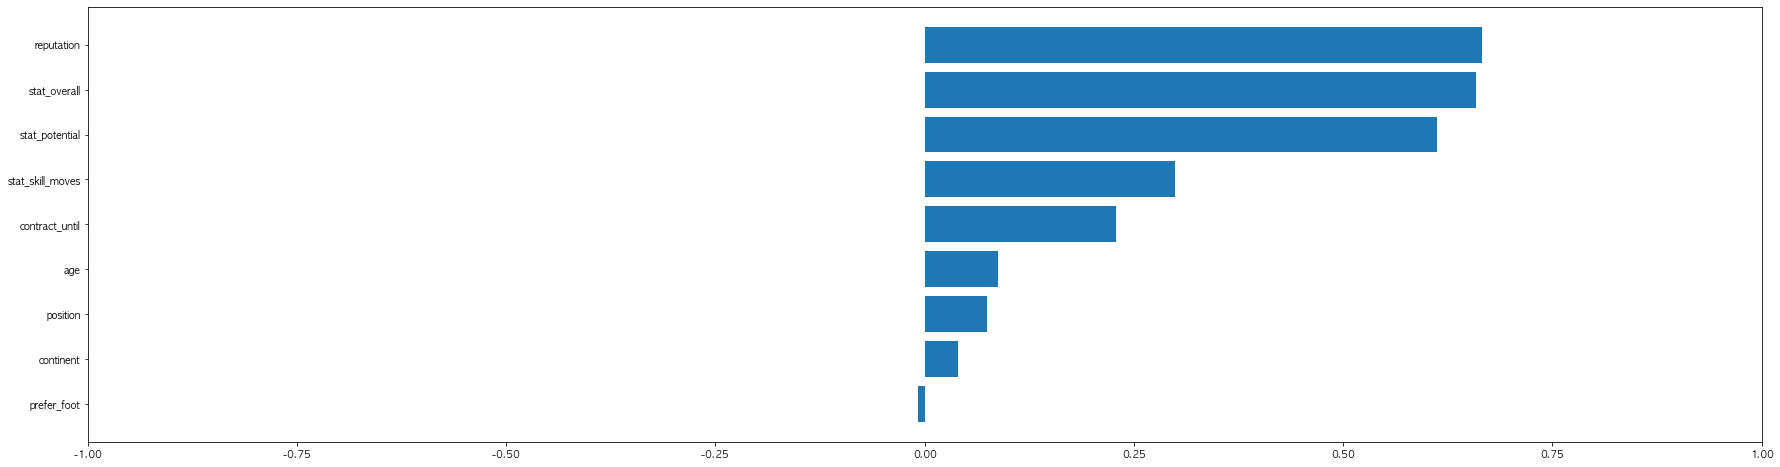

In [80]:
plt.figure(figsize=(30,8))
plt.barh(train_copy.drop('value',axis=1).corrwith(train['value']).sort_values().index,train_copy.drop('value',axis=1).corrwith(train['value']).sort_values())
plt.xlim(-1,1)
plt.show()

* reputatin, stat_overall, stat_potential의 상관 계수가 높습니다.

---
# Feature Engineering

### 나이에 따른 stat 변화

#### 나이에 따른 overall 변화

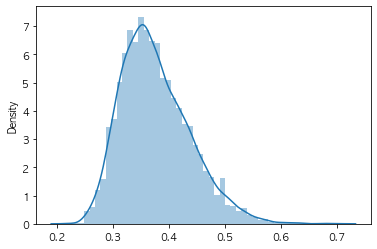

In [87]:
sns.distplot(train_copy['age']/train_copy['stat_overall'])
plt.show()

#### 나이에 따른 potential 변화

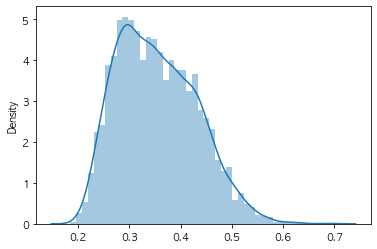

In [88]:
sns.distplot(train_copy['age']/train_copy['stat_potential'])
plt.show()

* 나이에 따른 능력치를 파생변수로 만들어 주겠습니다.

In [89]:
train_copy['age_overall'] = train_copy['age']/train_copy['stat_overall']
train_copy['age_potential'] = train_copy['age']/train_copy['stat_potential']
test_copy['age_overall'] = test_copy['age']/train_copy['stat_overall']
test_copy['age_potential'] = test_copy['age']/train_copy['stat_potential']

### 남은 계약 기간

In [90]:
train_copy['contract'] = train_copy['contract_until'] - 2018
test_copy['contract'] = test_copy['contract_until'] - 2018

* 계약기간에서 데이터 현재 연도인 2018년을 빼서 남은 계약 기간 변수를 만들어 주겠습니다.

In [91]:
train_copy['contract'].value_counts()

1    2899
3    2308
2    2051
4     761
5     506
0     391
6      12
7       3
8       1
Name: contract, dtype: int64

In [92]:
target = train_copy['value']
train_copy.drop('value',axis=1,inplace=True)

In [93]:
object_le = LabelEncoder()
train_copy[['continent','position','prefer_foot']] = train_copy[['continent','position','prefer_foot']].apply(object_le.fit_transform)

train_copy = pd.get_dummies(data= train_copy, columns=['continent'], prefix=['continent'])
train_copy = pd.get_dummies(data= train_copy, columns=['position'], prefix=['position'])
train_copy = pd.get_dummies(data= train_copy, columns=['prefer_foot'], prefix=['prefer_foot'])

test_copy[['continent','position','prefer_foot']] = test_copy[['continent','position','prefer_foot']].apply(object_le.fit_transform)
test_copy = pd.get_dummies(data= test_copy, columns=['continent'], prefix=['continent'])
test_copy = pd.get_dummies(data= test_copy, columns=['position'], prefix=['position'])
test_copy = pd.get_dummies(data= test_copy, columns=['prefer_foot'], prefix=['prefer_foot'])

In [94]:
scaler = RobustScaler()
train_copy[['age','stat_overall','stat_potential']] = scaler.fit_transform(train_copy[['age','stat_overall','stat_potential']])
test_copy[['age','stat_overall','stat_potential']] = scaler.transform(test_copy[['age','stat_overall','stat_potential']])

In [95]:
train_copy

,age,reputation,stat_overall,stat_potential,stat_skill_moves,age_overall,age_potential,contract,continent_0,continent_1,continent_2,continent_3,continent_4,position_0,position_1,position_2,position_3,prefer_foot_0,prefer_foot_1
0,0.857143,3.0,3.000000,2.750,4.0,0.329787,0.329787,3,0,0,0,0,1,0,0,0,1,1,0
1,0.285714,3.0,2.666667,2.625,1.0,0.296703,0.290323,2,0,0,1,0,0,0,1,0,0,0,1
2,0.857143,3.0,2.666667,2.375,3.0,0.340659,0.340659,3,0,0,0,0,1,0,0,0,1,0,1
3,1.000000,3.0,2.666667,2.375,3.0,0.351648,0.351648,2,0,0,1,0,0,1,0,0,0,0,1
4,0.000000,3.0,2.555556,2.625,1.0,0.277778,0.268817,3,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,-1.000000,1.0,-2.111111,-1.125,3.0,0.375000,0.285714,1,1,0,0,0,0,0,0,1,0,0,1
8928,-0.857143,1.0,-2.222222,-1.625,2.0,0.404255,0.322034,2,0,0,1,0,0,1,0,0,0,0,1
8929,-1.000000,1.0,-2.222222,-1.000,2.0,0.382979,0.281250,3,0,0,0,0,1,1,0,0,0,0,1
8930,-1.000000,1.0,-2.222222,-0.875,1.0,0.382979,0.276923,3,0,0,1,0,0,0,1,0,0,0,1


In [96]:
# 메타 모델을 위한 학습 및 테스트 데이터 만들기
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True,random_state=42)
    # 빈 배열 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('폴드 세트 : ', folder_counter, ' 시작')
        X_tr = X_train_n.iloc[train_index]
        y_tr = y_train_n.iloc[train_index]
        X_te = X_train_n.iloc[valid_index] 
        
        # 폴드 내 모델 학습
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1) # y_train 예측, 폴드 끝나면 concat해야함
        test_pred[:, folder_counter] = model.predict(X_test_n) # y_test 예측, 폴드 끝나면 평균 낼거임
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean # 하나의 모델에 대한 학습데이터, 테스트 데이터 생성

In [97]:
# 가장 좋은 점수를 받은 모델
# dt,rf 없는 버전
# 객체 생성

ada_reg = AdaBoostRegressor(random_state=42)
gbm_reg = GradientBoostingRegressor(random_state=42)
cat_reg = cb.CatBoostRegressor(random_state=42)
et_reg = ExtraTreesRegressor(random_state=42)
xgb_final = xgb.XGBRegressor(random_state=42)
lgbm_reg = LGBMRegressor(random_state=42)

# 개별 모델로부터 메타 모델에 필요한 데이터 셋 만들기

ada_train, ada_test = get_stacking_base_datasets(ada_reg, train_copy, target, test_copy, 5)
gbm_train, gbm_test = get_stacking_base_datasets(gbm_reg, train_copy, target, test_copy, 5)
cat_train, cat_test = get_stacking_base_datasets(cat_reg, train_copy, target, test_copy, 5)
et_train, et_test = get_stacking_base_datasets(et_reg, train_copy, target, test_copy, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, train_copy, target, test_copy, 5)

# 개별 모델로부터 나온 y_train 예측값들 옆으로 붙이기
Stack_final_X_train = np.concatenate((ada_train,gbm_train,cat_train,et_train,lgbm_train), axis=1)
# 개별 모델로부터 나온 y_test 예측값들 옆으로 붙이기
Stack_final_X_test = np.concatenate((ada_test,gbm_test,cat_test,et_test,lgbm_test), axis=1)

xgb_final.fit(Stack_final_X_train, target)
stack_final = xgb_final.predict(Stack_final_X_test) 

폴드 세트 :  0  시작
폴드 세트 :  1  시작
폴드 세트 :  2  시작
폴드 세트 :  3  시작
폴드 세트 :  4  시작
폴드 세트 :  0  시작
폴드 세트 :  1  시작
폴드 세트 :  2  시작
폴드 세트 :  3  시작
폴드 세트 :  4  시작
폴드 세트 :  0  시작
Learning rate set to 0.055861
0:	learn: 1.3202197	total: 59.2ms	remaining: 59.1s
1:	learn: 1.2550901	total: 61.2ms	remaining: 30.6s
2:	learn: 1.1936388	total: 62.8ms	remaining: 20.9s
3:	learn: 1.1373226	total: 64.7ms	remaining: 16.1s
4:	learn: 1.0838145	total: 66.1ms	remaining: 13.2s
5:	learn: 1.0318427	total: 67.8ms	remaining: 11.2s
6:	learn: 0.9854652	total: 69.3ms	remaining: 9.83s
7:	learn: 0.9380715	total: 70.9ms	remaining: 8.79s
8:	learn: 0.8942465	total: 72.5ms	remaining: 7.98s
9:	learn: 0.8531059	total: 74.2ms	remaining: 7.34s
10:	learn: 0.8143469	total: 75.5ms	remaining: 6.79s
11:	learn: 0.7771317	total: 77ms	remaining: 6.34s
12:	learn: 0.7431331	total: 78.2ms	remaining: 5.94s
13:	learn: 0.7105649	total: 79.9ms	remaining: 5.63s
14:	learn: 0.6805042	total: 81.3ms	remaining: 5.34s
15:	learn: 0.6497471	total: 82.6ms	re

In [98]:
np.expm1(stack_final)

array([6.4086984e+07, 1.0729951e+08, 7.3556016e+07, ..., 5.6956457e+04,
       5.1971547e+04, 5.2579367e+04], dtype=float32)

In [99]:
submission['value'] = np.expm1(stack_final)
submission.to_csv('stacking eda.csv',index=False)